In [1]:
using PyPlot

# Sequential Inference of Cascading Latent Force Model

$$
\frac{\partial}{\partial t}f_1(\cdot,t) = \mathcal{A}_1f_1(\cdot,t) + \mathcal{B}_1u(\cdot,t)
$$
$$
\frac{\partial}{\partial t}f_2(\cdot,t) = \mathcal{A}_2f_2(\cdot,t) + \mathcal{B}_2f_1(\cdot,t)
$$
$$
\vdots
$$
$$
\frac{\partial}{\partial t}f_n(\cdot,t) = \mathcal{A}_nf_n(\cdot,t) + \mathcal{B}_nf_{n-1}(\cdot,t)
$$
$$
y(\cdot,t) = \mathcal{H}f_n(\cdot,t) + \nu(\cdot, t),\qquad \nu \sim \mathcal{N}(\mathbf{0}, \mathbf{R})
$$

### Example: brine tank cascade

(taken from [here](http://www.math.utah.edu/~gustafso/s2008/systemsBrineTankHeating.pdf))

```
    ‚Üì ___
   | (1) |__
   |_______‚Ü¥|____
        |        |___
        |  (2)    __‚Ü¥|_________
        |________| |           |
                   |   (3)     |
                   |_____     _|
                         | ‚Üì |
```
Brine tanks, (1),(2),(3) with fixed volume. Assumption that the fluid enters each tank at a rate of $r^{(i)}_{in}$ and out of each tank at a rate of $r^{(i)}_{out}$, where $i$ is the tank number. In the basic case, it is assumed that the volume is fixed, such that $r^{(i)}_{in} = r^{(i-1)}_{out}$ for $i = 2,3$. Modelling the amount of salt in each tank at a given time, assume uniform concentration in a given tank, and that there is some initial concentration of salt in each tank and that there is some input of unknown (variable) concentration at a given time.

$$
    \frac{\mathrm{d}}{\mathrm{d}t}f_1(t) = a_1f_1(t) + u(t)
$$
$$
    \frac{\mathrm{d}}{\mathrm{d}t}f_2(t) = a_2f_2(t) - a_1f_1(t)
$$
$$
    \frac{\mathrm{d}}{\mathrm{d}t}f_3(t) = a_3f_3(t) - a_2f_2(t)
$$

The concentration in each tank cannot be directly observed, so the observation is the output from tank (3) with additive Gaussian noise:
$$
    y(t) = -a_3f_3(t) + \nu(t)
$$

Modelling the input function $u(t)$ as a Gaussian process gives a system of stochastic differential equations, where the concentration of salt in each tank, $f_i$ is also a Gaussian process.

Modelling the system as a joint Gaussian distribution gives the following single latent force model:

$$
    \frac{\mathrm{d}}{\mathrm{d}t}\mathbf{f}(t) = \mathbf{A}\mathbf{f}(t) + \mathbf{L}u(t)
$$
$$
    y(t) = \mathbf{H}\mathbf{f}(t) + \nu(t)
$$

Where 

$$ \mathbf{f}(t) = \begin{bmatrix}f_1(t)\\ f_2(t)\\ f_3(t)\end{bmatrix}, \qquad
    \mathbf{A} = \begin{bmatrix}
        a_1 & 0 & 0 \\
        -a_1 & a_2 & 0 \\ 
        0 & -a_2 & a_3
    \end{bmatrix}, \qquad \mathbf{L} = \begin{bmatrix}1 \\ 0 \\ 0\end{bmatrix}
$$

$$
    \mathbf{H} = \begin{bmatrix}0 & 0 & 1\end{bmatrix}
$$

## Modelling

In [2]:
a‚ÇÅ, a‚ÇÇ, a‚ÇÉ = -1./2., -1./4., -1./6.
ùêü‚ÇÄ = [2, 5, 2.5] # initial concentration of salt in each tank

ùêÄ = [ a‚ÇÅ  0.  0. ;
     -a‚ÇÅ  a‚ÇÇ  0. ;
      0. -a‚ÇÇ  a‚ÇÉ ]

ùêã = [1 ; 0 ; 0]
; #suppress output

In [3]:
## Discretise system
n‚Çú = 1000
ùê≠ = linspace(0., 5., n‚Çú)

Œî‚Çú = ùê≠[2] - ùê≠[1] # discretise
ùêÖ  = expm(Œî‚Çú * ùêÄ);

### Model solution with no saline input
This assumes tank 1 is being filled with 0-concentration water

In [4]:
# Analytic solution for no input
ùëì(t) = [  [ùêü‚ÇÄ[1]*exp.(-t/2)] ;
        [-2ùêü‚ÇÄ[1]*exp.(-t/2) + (ùêü‚ÇÄ[2] + 2ùêü‚ÇÄ[1])*exp.(-t/4)] ; 
         [1.5*ùêü‚ÇÄ[1]*exp.(-t/2) - 3*(ùêü‚ÇÄ[2] + 2ùêü‚ÇÄ[1])*exp.(-t/4) + (ùêü‚ÇÄ[3]-1.5*ùêü‚ÇÄ[1] + 3*(ùêü‚ÇÄ[2] + 2ùêü‚ÇÄ[1]))*exp.(-t/6)]]
; # suppress output

In [5]:
ùíá‚Çú = Array{typeof(ùêü‚ÇÄ)}(n‚Çú)
#ùêü‚Çú = ùêü‚ÇÄ
ùíá‚Çú[1] = ùêü‚ÇÄ

for k ‚àà 2:n‚Çú
    ùíá‚Çú[k] = ùêÖ * ùíá‚Çú[k-1]
end

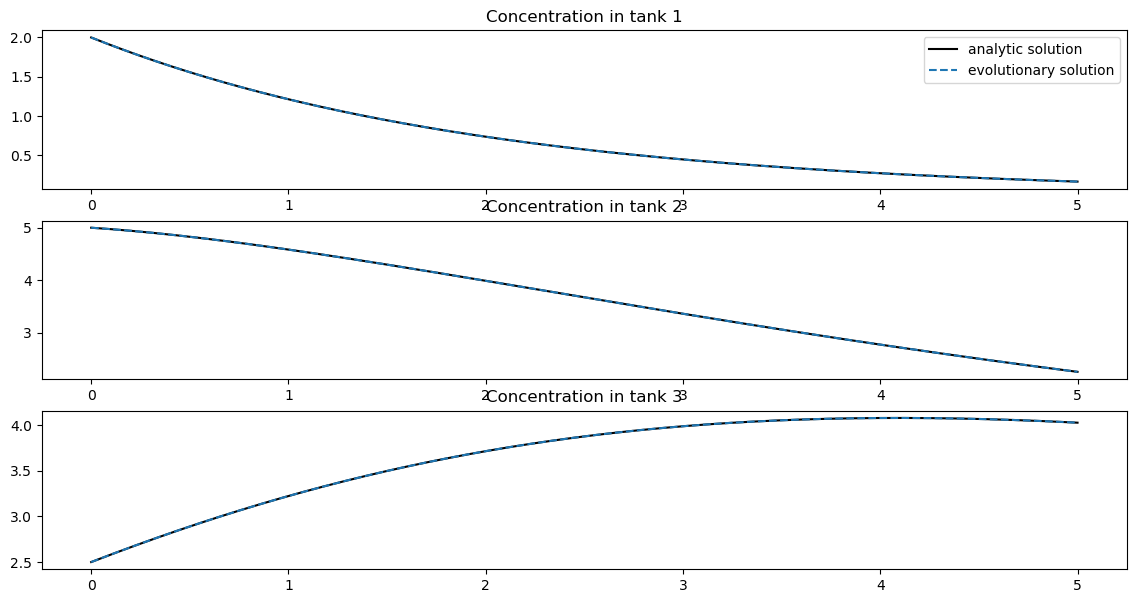

In [6]:
#_,axs = subplots(4,1,:true,:false)

figure(figsize=(14,7))

for i ‚àà 1:3
    subplot(310+i)
    plot(ùê≠, ùëì(ùê≠)[i],"k-")
    plot(ùê≠, [f[i] for f ‚àà ùíá‚Çú],"--")
    title(@sprintf("Concentration in tank %d", i))
    i == 1 ? legend(labels=["analytic solution", "evolutionary solution"]) : nothing
end
;

### Model the input

Now add an input function to the model:

In [7]:
## Input
# Injection start and stop times
t‚Çõ‚Çú‚Çê·µ£‚Çú, t‚Çõ‚Çú‚Çí‚Çö = [0.1, 1.8, 3.], [0.4, 2., 4.]
# Injection gradient (controls slope of injection from 0 to 1 and vice versa)
œÉ·µ§ = 100.

ùë¢(t)  = sum([(1 + exp.(œÉ·µ§*(a-t))).^(-1).*(1 + exp.(œÉ·µ§*(t-b))).^(-1) for (a,b) ‚àà zip(t‚Çõ‚Çú‚Çê·µ£‚Çú, t‚Çõ‚Çú‚Çí‚Çö)])
‚à´ùë¢(t) = sum([(log.(exp.(œÉ·µ§*(a-b))+exp.(œÉ·µ§*(a-t)))-log.(exp.(œÉ·µ§*(a-t))+1))/(œÉ·µ§*(exp(œÉ·µ§*(a-b))-1)) for (a,b) ‚àà zip(t‚Çõ‚Çú‚Çê·µ£‚Çú, t‚Çõ‚Çú‚Çí‚Çö)]) 

‚à´ùë¢ (generic function with 1 method)

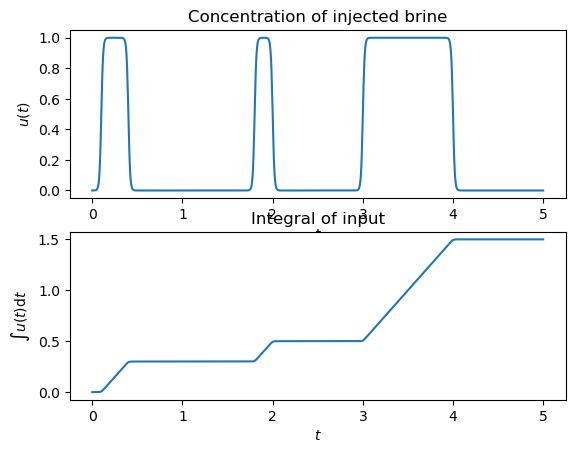

PyObject Text(0.5,1,'Integral of input')

In [8]:
subplot(211)
plot(ùê≠, ùë¢(ùê≠), "-")
xlabel(L"$t$"), ylabel(L"$u(t)$")
title("Concentration of injected brine");

subplot(212)
plot(ùê≠, ‚à´ùë¢(ùê≠),"-")
xlabel(L"$t$"), ylabel(L"$\int u(t)\mathrm{d}t$")
title("Integral of input")

In [9]:
ùíá‚Çú = Array{typeof(ùêü‚ÇÄ)}(n‚Çú)

ùíá‚Çú[1] = ùêü‚ÇÄ
for k ‚àà 2:n‚Çú
    ùíá‚Çú[k] = ùêÖ * ùíá‚Çú[k-1] + ùêã*(‚à´ùë¢(ùê≠[k]) - ‚à´ùë¢(ùê≠[k-1]))
end

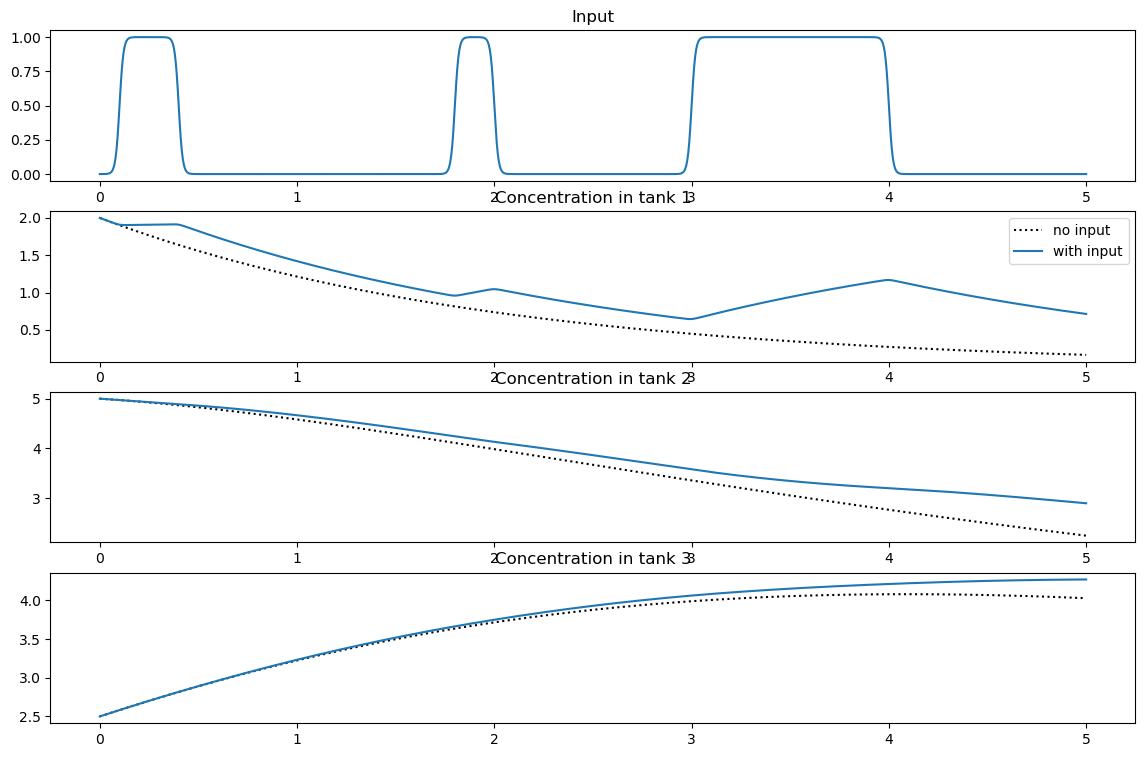

In [10]:
figure(figsize=(14,9))

subplot(411)
plot(ùê≠, ùë¢(ùê≠), "-")
title("Input")

for i ‚àà 1:3
    subplot(411+i)
    plot(ùê≠, ùëì(ùê≠)[i],"k:")
    plot(ùê≠, [f[i] for f ‚àà ùíá‚Çú],"-")
    title(@sprintf("Concentration in tank %d", i))
    i == 1 ? legend(labels=["no input","with input"]) : nothing
end
;

## An observation model

$$ y(t) = -a_3f_3(t) + \nu(t),\qquad \nu \sim \mathcal{N}(0, \sigma^2_\nu)$$

Sample for some discrete number of points in time

In [11]:
n‚Çõ = 100

ùê≤‚Çú = Array{typeof(ùêü‚ÇÄ)}(n‚Çõ)
ùê≠‚Çõ = linspace(0., 5., n‚Çõ)

ùêá  = [0 0 -a‚ÇÉ]
ùëπ  = 0.01 # observation noise covariance

ùëì‚Çú = ùêü‚ÇÄ

ùê≤‚Çú[1] = ùêá*ùêü‚ÇÄ

for k ‚àà 2:n‚Çõ
    ùëì‚Çú = expm((ùê≠‚Çõ[k]-ùê≠‚Çõ[k-1])*ùêÄ) * ùëì‚Çú + ùêã*(‚à´ùë¢(ùê≠‚Çõ[k]) - ‚à´ùë¢(ùê≠‚Çõ[k-1]))
    ùê≤‚Çú[k] = ùêá*ùëì‚Çú + ‚àöùëπ * randn()
end

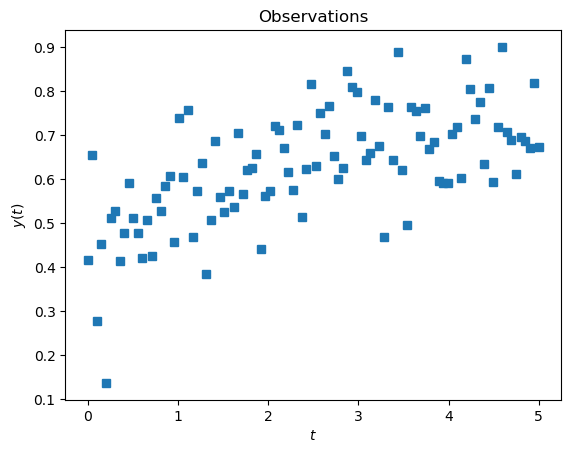

PyObject Text(0.5,1,'Observations')

In [12]:
plot(ùê≠‚Çõ, ùê≤‚Çú, "s")
xlabel(L"t"), ylabel(L"y(t)")
title("Observations")

## Learning the input u(t)

The idea is to model the latent force, $u(t)$, which is a GP, as a linear time-invariance SDE (as in [Hartikainen and Sarkka, (2011)](https://users.aalto.fi/~ssarkka/pub/silfm_uai2011.pdf)):


First, the following example shows GP regression for some discrete-time samples. The Matern-$\frac{3}{2}$ covariance function is used, with $\mathscr{l} = 0.5$ and $\sigma_\kappa^2 = 1.$

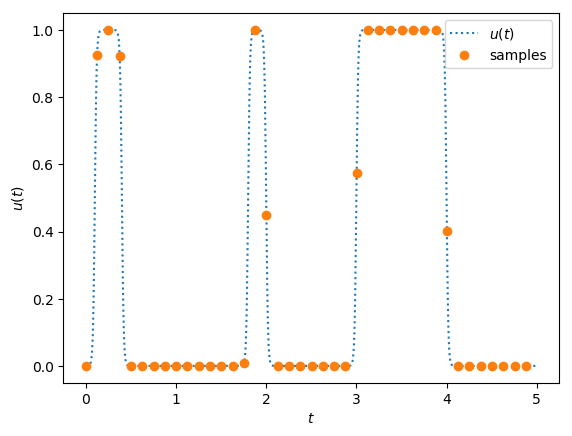

In [13]:
ùê≠·µ§ = ùê≠[1:25:end]

plot(ùê≠, ùë¢(ùê≠), ":", ùê≠·µ§, ùë¢(ùê≠·µ§), "o")
xlabel(L"$t$"), ylabel(L"$u(t)$")
legend(labels=[L"u(t)", "samples"])
; #suppress text output

In [14]:
include("GP.jl")
params = Dict("nu" => 1.5, "lengthscale"=>0.5, "variance"=>1.)

gp_predict = trained_gp(ùê≠·µ§, ùë¢(ùê≠·µ§), œÉ¬≤=eps(), ùëò=kern_matern, Œ∏=params)

Œº, Œ£ = gp_predict(ùê≠);

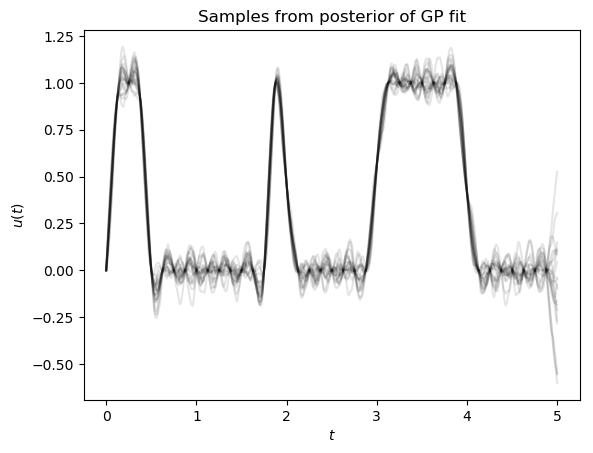

In [15]:
s = sample_posterior(Œº, Œ£, n=20)
for i ‚àà 1:20
    plot(ùê≠, s[i], "k-", alpha=0.1)
end
title("Samples from posterior of GP fit")
xlabel(L"$t$"), ylabel(L"$u(t)$");

_Obviously this is not great, since the function cannot be Gaussian output, since strictly >0_

## Construct SDE representation of u(t)

Taking the covariance function used in the GP regression,

$$
\kappa_u(t,t') = \sigma^2_\kappa\left(1 + \frac{\sqrt{3}|t-t'|}{\mathscr{l}}\right)\exp\left(-\frac{\sqrt{3}|t-t'|}{\mathscr{l}}\right)
$$

The LTI SDE representation of $u(t) \sim \mathcal{GP}(0, \kappa_u(t,t'))$ is:

$$
\frac{\mathrm{d}}{\mathrm{d}t}\mathbf{u}(t) = \underbrace{\begin{bmatrix}0 & 1 \\ -\lambda^2 & -2\lambda\end{bmatrix}}_{\mathscr{F}_u}\mathbf{u}(t) + \underbrace{\begin{bmatrix}0\\1\end{bmatrix}}_{\mathcal{L}_u}\mathbf{w}(t)
$$

Where $u(t) = \begin{bmatrix}1&0\end{bmatrix}\mathbf{u}(t)$, $\lambda = \sqrt{3}/\mathscr{l}$, and $\mathbf{P}_\infty = \mathrm{diag}[\sigma_\kappa^2 , \lambda^2\sigma_\kappa^2]$, $q = \frac{4\lambda^3}{\sigma_\kappa^2}$

In [16]:
l, œÉ‚Çñ¬≤ = 0.5, 1.
Œª = ‚àö3 / l

‚Ñ± = [0 1 ; -Œª^2 -2Œª]
P‚àû = diagm([œÉ‚Çñ¬≤, Œª^2*œÉ‚Çñ¬≤])
Œ∫·µ§(t) = kern_matern(t, 0., ŒΩ=3/2, ls=l, v = œÉ‚Çñ¬≤) # explicit covariance definition
ùê∂·µ§(t) = t ‚â• 0. ? [1 0]*P‚àû*expm(t*‚Ñ±)'*[1;0] : [1 0]*expm(-t*‚Ñ±)*P‚àû*[1;0]; # SSM-based definition

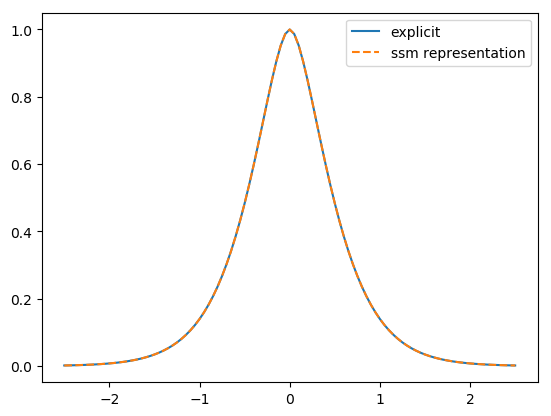

PyObject <matplotlib.legend.Legend object at 0x7f07345f07f0>

In [17]:
œÑ = -5l:l/10.:5l

plot(œÑ, map(Œ∫·µ§, œÑ), "-", œÑ, map(ùê∂·µ§, œÑ), "--")
legend(labels=["explicit", "ssm representation"])

In [18]:
filter = (F,Q,H,R)->((m,P)->(F*m,F*P*F'+Q),(m,P,y)->(m+(P*H'/(H*P*H'+R))*(y-H*m),P-(P*H'/(H*P*H'+R))*(H*P*H'+R)*(P*H'/(H*P*H'+R))'))
smoother = (F,Q)->((m‚Åª,m‚Å∫,P‚Åª,P‚Å∫)->(m‚Åª+(P‚Åª*F'/(F*P‚Åª*F'+Q))*(m‚Å∫-F*m‚Åª),P‚Åª*(F*P‚Åª*F'+Q)*(P‚Å∫-F*P‚Åª*F'+Q)*(F*P‚Åª*F'+Q)'))

(::#80) (generic function with 1 method)

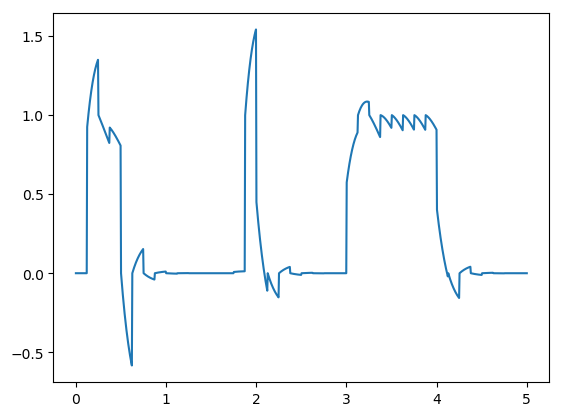

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f0730296438>

In [19]:
m‚ÇÄ, P‚ÇÄ = [0.;0.], P‚àû

m, P = Array{typeof(m‚ÇÄ)}(n‚Çú), Array{typeof(P‚ÇÄ)}(n‚Çú)

ùíú = expm(Œî‚Çú*‚Ñ±)
predict, update = filter(ùíú, P‚àû - ùíú*P‚àû*ùíú', [1. 0.], eps())

m‚Çú, P‚Çú = m‚ÇÄ, P‚ÇÄ
for k ‚àà 1:n‚Çú
    m‚Çú, P‚Çú = predict(m‚Çú, P‚Çú)
    if ùê≠[k] ‚àà ùê≠·µ§
        m‚Çú, P‚Çú = update(m‚Çú, P‚Çú, ùë¢(ùê≠[k]))
    end
    m[k] = m‚Çú
    P[k] = P‚Çú
end

plot(ùê≠, map(ùúá -> [1 0]*ùúá, m), "-")

In [20]:
smooth = smoother(ùíú, P‚àû - ùíú*P‚àû*ùíú')

for k = n‚Çú-1:-1:1
    m[k], P[k] = smooth(m[k],m[k+1],P[k],P[k+1]) 
end

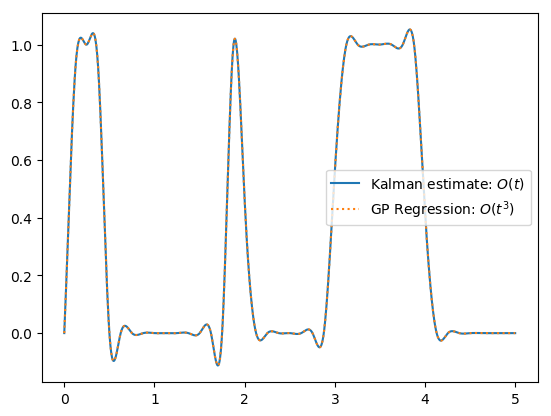

PyObject <matplotlib.legend.Legend object at 0x7f07301e2780>

In [21]:
plot(ùê≠, map(ùúá -> [1 0]*ùúá, m), "-")
plot(ùê≠, Œº, ":")

legend(labels=[L"Kalman estimate: $O(t)$", L"GP Regression: $O(t^3)$"])

# Augment the system with the SDE parameterisation of u(t)


$$
    \frac{\mathrm{d}}{\mathrm{d}t}\mathbf{f}^a(t) = \mathbf{A}^a\mathbf{f}^a(t) + \mathbf{L}^a\mathbf{w}(t)
$$
$$
    y(t) = \mathbf{H}\mathbf{f}(t) + \nu(t)
$$

Where 

$$ \mathbf{f}^a(t) = \begin{bmatrix}\mathbf{u}(t)\\f_1(t)\\ f_2(t)\\ f_3(t)\end{bmatrix}, \qquad
    \mathbf{A} = \begin{bmatrix}
      0 & 1 & 0 & 0 & 0\\
     -\lambda^2 & -2\lambda & 0 & 0 & 0\\
      1 & 0 & a_1 & 0 & 0 \\
      0 & 0 & -a_1 & a_2 & 0 \\ 
      0 & 0 &  0 & -a_2 & a_3
    \end{bmatrix}, \qquad \mathbf{L} = \begin{bmatrix}0 \\ 1 \\ 0 \\ 0 \\ 0\end{bmatrix}
$$

$$
    \mathbf{H} = \begin{bmatrix}0 & 0 & 1\end{bmatrix}
$$

In [22]:
a‚ÇÅ, a‚ÇÇ, a‚ÇÉ = -1./2., -1./4., -1./6.
ùêü‚ÇÄ = [0., 0., 2, 5, 2.5] # initial conditions

ùêÄ = [   0.   1. 0.  0.  0. ;
       -Œª^2 -2Œª 0.  0.  0. ;
        1.   0. a‚ÇÅ  0.  0. ;
        0.   0. -a‚ÇÅ  a‚ÇÇ  0.;
        0.   0. 0. -a‚ÇÇ  a‚ÇÉ ]

ùêÖ = expm(Œî‚Çú*ùêÄ)
ùêê = [ P‚àû - ùíú*P‚àû*ùíú' zeros(2, 3) ; zeros(3, 5)] # ??? Need to work out discretisation of this

 #?m‚ÇÄ, P‚ÇÄ = [P‚àû * ]

; #suppress output